In [3]:
from huggingface_hub import notebook_login

#notebook_login()

In [4]:
import os
import logging
import sys
import json
from collections import Counter
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from typing import Dict, List

# --- Scikit-learn Imports ---
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix

# --- Hugging Face Imports ---
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

# --- Imports from the project's config file ---
sys.path.append(os.path.abspath(os.path.join('..')))
from config import (
    PROCESSED_DATA_DIR, TRAIN_FILE, VAL_FILE, TEST_FILE,
    TEXT_COLUMN, PERSON_COUPLE_COLUMN
)
print("Variables loaded successfully from config.py")


MODEL_NAME = 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'

# Logger Configuration
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] - %(message)s", stream=sys.stdout)



Variables loaded successfully from config.py


In [5]:
def load_and_flatten_data(file_path: str) -> List[Dict]:
    """Loads a JSON file and flattens it into a list of turns."""
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    turn_data = []
    for conversation in data:
        conv_id = conversation['conversation_id']
        label = conversation.get(PERSON_COUPLE_COLUMN, 'Unknown')
        for i, turn in enumerate(conversation.get('dialogue', [])):
            turn_data.append({
                'conversation_id': conv_id,
                'turn_id': i,
                TEXT_COLUMN: turn.get('text', ''),
                PERSON_COUPLE_COLUMN: label
            })
    return turn_data

logging.info("Loading and preparing data at the turn level...")
train_path = os.path.join(PROCESSED_DATA_DIR, TRAIN_FILE)
val_path = os.path.join(PROCESSED_DATA_DIR, VAL_FILE)
test_path = os.path.join(PROCESSED_DATA_DIR, TEST_FILE)

# Load raw test data for the final conversation-level evaluation
with open(test_path, 'r', encoding='utf-8') as f:
    raw_test_conversations = json.load(f)

# Combine train and validation for a larger training set and create DataFrames
train_val_turns_df = pd.DataFrame(load_and_flatten_data(train_path) + load_and_flatten_data(val_path))
test_turns_df = pd.DataFrame(load_and_flatten_data(test_path))

logging.info(f"Data loaded: {len(train_val_turns_df)} turns for training/validation, {len(test_turns_df)} turns for testing.")

# Create numerical labels (id2label and label2id)
unique_labels = sorted(train_val_turns_df[PERSON_COUPLE_COLUMN].unique().tolist())
id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}

train_val_turns_df['label'] = train_val_turns_df[PERSON_COUPLE_COLUMN].map(label2id)
test_turns_df['label'] = test_turns_df[PERSON_COUPLE_COLUMN].map(label2id)

# Split the training set into train and validation by conversation_id
train_conv_ids, val_conv_ids = train_test_split(
    train_val_turns_df['conversation_id'].unique(),
    test_size=0.15,
    random_state=42
)

final_train_df = train_val_turns_df[train_val_turns_df['conversation_id'].isin(train_conv_ids)]
final_val_df = train_val_turns_df[train_val_turns_df['conversation_id'].isin(val_conv_ids)]

logging.info(f"Data split into: {len(final_train_df)} training turns, {len(final_val_df)} validation turns.")

# Create the final Hugging Face DatasetDict
raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(final_train_df),
    'validation': Dataset.from_pandas(final_val_df),
    'test': Dataset.from_pandas(test_turns_df)
})

print("\nTurn-level Dataset Structure:\n", raw_datasets)

2025-08-14 10:21:25,187 [INFO] - Loading and preparing data at the turn level...
2025-08-14 10:21:25,211 [INFO] - Data loaded: 6676 turns for training/validation, 1291 turns for testing.
2025-08-14 10:21:25,216 [INFO] - Data split into: 5641 training turns, 1035 validation turns.

Turn-level Dataset Structure:
 DatasetDict({
    train: Dataset({
        features: ['conversation_id', 'turn_id', 'conversation', 'person_couple', 'label', '__index_level_0__'],
        num_rows: 5641
    })
    validation: Dataset({
        features: ['conversation_id', 'turn_id', 'conversation', 'person_couple', 'label', '__index_level_0__'],
        num_rows: 1035
    })
    test: Dataset({
        features: ['conversation_id', 'turn_id', 'conversation', 'person_couple', 'label'],
        num_rows: 1291
    })
})


In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def tokenize_function(examples):
    """Tokenizes the text."""
    return tokenizer(examples[TEXT_COLUMN], padding="max_length", truncation=True, max_length=512)

logging.info("Tokenizing the datasets...")
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels", "conversation_id"])

print("\nExample of a tokenized item:\n", tokenized_datasets["train"][0])

2025-08-14 10:21:26,477 [INFO] - Tokenizing the datasets...


Map:   0%|          | 0/5641 [00:00<?, ? examples/s]

Map:   0%|          | 0/1035 [00:00<?, ? examples/s]

Map:   0%|          | 0/1291 [00:00<?, ? examples/s]


Example of a tokenized item:
 {'conversation_id': tensor(776), 'labels': tensor(5), 'input_ids': tensor([     0,     44,   8912,    157,   9587,     23,  77328,     17,  37110,
           290, 112234,  19004,    188,    211,  19977,  65672,      5,   3775,
           221,     40,    565,    211,   2941,     45,  51800,  25415,   1829,
            36,  44563,  25415,  40778,   1242,      2,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Helper Functions and Classes ---

def compute_metrics_for_trainer(p):
    """Calculates metrics (accuracy and F1) for the Trainer during training."""
    preds = np.argmax(p.predictions, axis=1)
    f1 = precision_recall_fscore_support(p.label_ids, preds, average='weighted', zero_division=0)[2]
    acc = accuracy_score(p.label_ids, preds)
    return {'accuracy': acc, 'f1': f1}

class CustomTrainer(Trainer):
    """Custom trainer to use class weights during loss calculation."""
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.model.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

class LLMEvaluator:
    """Class to manage the conversation-level evaluation of the model."""
    def __init__(self, trainer, tokenized_test_set, test_turns_df, raw_test_conversations, id2label):
        self.trainer = trainer
        self.tokenized_test_set = tokenized_test_set
        self.test_turns_df = test_turns_df.copy()
        self.raw_test_conversations = raw_test_conversations
        self.id2label = id2label
        self.label2id = {v: k for k, v in id2label.items()}
        self.class_names = list(id2label.values())

    def _get_conversation_level_probabilities(self):
        logging.info("Running predictions on the test set at the turn level...")
        test_predictions = self.trainer.predict(self.tokenized_test_set)
        logits = torch.tensor(test_predictions.predictions)
        probs = F.softmax(logits, dim=-1).numpy()
        self.test_turns_df['probabilities'] = list(probs)
        
        conversation_probs = {}
        grouped = self.test_turns_df.groupby('conversation_id')
        for conv_id, group in grouped:
            mean_prob = np.mean(np.vstack(group['probabilities'].values), axis=0)
            conversation_probs[conv_id] = mean_prob
        return conversation_probs

    def evaluate_and_report(self):
        conv_probs = self._get_conversation_level_probabilities()
        
        y_true_labels = [conv[PERSON_COUPLE_COLUMN] for conv in self.raw_test_conversations]
        y_true_encoded = [self.label2id.get(label) for label in y_true_labels]

        conversation_order = [conv['conversation_id'] for conv in self.raw_test_conversations]
        y_pred_probs = np.array([conv_probs[cid] for cid in conversation_order])
        
        top_k_indices = np.argsort(y_pred_probs, axis=1)[:, ::-1]
        top_1_preds_indices = top_k_indices[:, 0]
        top_2_preds_indices = top_k_indices[:, :2]
        top_3_preds_indices = top_k_indices[:, :3]
        y_pred_labels_top1 = [self.id2label[i] for i in top_1_preds_indices]

        overall_accuracy_top1 = accuracy_score(y_true_labels, y_pred_labels_top1)
        overall_accuracy_top2 = np.mean([y_true_encoded[i] in top_2_preds_indices[i] for i in range(len(y_true_encoded))])
        overall_accuracy_top3 = np.mean([y_true_encoded[i] in top_3_preds_indices[i] for i in range(len(y_true_encoded))])

        report_dict_top1 = classification_report(y_true_labels, y_pred_labels_top1, zero_division=0, output_dict=True, labels=self.class_names)
        
        results_data = []
        for class_index, class_name in enumerate(self.class_names):
            class_metrics = report_dict_top1.get(class_name, {})
            indices_of_class = np.where(np.array(y_true_encoded) == class_index)[0]
            class_top2_accuracy = np.sum([y_true_encoded[i] in top_2_preds_indices[i] for i in indices_of_class]) / len(indices_of_class) if len(indices_of_class) > 0 else 0.0
            class_top3_accuracy = np.sum([y_true_encoded[i] in top_3_preds_indices[i] for i in indices_of_class]) / len(indices_of_class) if len(indices_of_class) > 0 else 0.0

            results_data.append({
                'Precision': class_metrics.get('precision', 0),
                'Recall (Top-1 Acc)': class_metrics.get('recall', 0),
                'F1-Score': class_metrics.get('f1-score', 0),
                'Top-2 Accuracy': class_top2_accuracy,
                'Top-3 Accuracy': class_top3_accuracy,
                'Support': int(class_metrics.get('support', 0))
            })
        results_df = pd.DataFrame(results_data, index=self.class_names)
        results_df.index.name = "Class"
        
        print("\n" + "="*85)
        print("  DETAILED PERFORMANCE REPORT (Based on Averaged Turn Probabilities)  ")
        print("="*85)
        formatted_df = results_df.copy()
        for col in formatted_df.columns:
            if col != 'Support':
                formatted_df[col] = formatted_df[col].apply(lambda x: f"{x:.2%}")
        print(formatted_df.to_string())
        print("\n" + "-"*85)
        print("Overall Performance Summary:")
        print(f"  - Top-1 Accuracy: {overall_accuracy_top1:.2%}")
        print(f"  - Top-2 Accuracy: {overall_accuracy_top2:.2%}")
        print(f"  - Top-3 Accuracy: {overall_accuracy_top3:.2%}")
        print("="*85 + "\n")
        
        report_path = 'classification_report_top_k.txt'
        with open(report_path, "w", encoding='utf-8') as f:
            f.write(formatted_df.to_string())
        logging.info(f"Detailed classification report saved to '{report_path}'")
        
        return {'y_true': y_true_labels, 'y_pred_top1': y_pred_labels_top1}

    def plot_confusion_matrix(self, y_true, y_pred, file_path='confusion_matrix.png'):
        logging.info("Generating the confusion matrix...")
        cm = confusion_matrix(y_true, y_pred, labels=self.class_names)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names)
        plt.title('Confusion Matrix (Top-1 Predictions)', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.xticks(rotation=45, ha="right")
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(file_path)
        logging.info(f"Confusion matrix saved to '{file_path}'")
        plt.show()

    def plot_training_history(self, file_prefix='training_plot'):
        logging.info("Creating training progress plots...")
        log_history = self.trainer.state.log_history
        eval_logs = [log for log in log_history if 'eval_loss' in log]
        if not eval_logs:
            logging.warning("Not enough evaluation log data to create plots.")
            return
        eval_df = pd.DataFrame(eval_logs)
        
        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=(12, 6))
        plt.plot(eval_df['epoch'], eval_df['eval_loss'], 'o-', label='Validation Loss')
        plt.title('Validation Loss Progression', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.legend(fontsize=12)
        plt.xticks(np.arange(0, int(eval_df['epoch'].max()) + 2, 1))
        plt.tight_layout()
        plt.savefig(f'{file_prefix}_loss.png')
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(eval_df['epoch'], eval_df['eval_f1'], 'o-', label='Validation F1-Score', color='green')
        plt.plot(eval_df['epoch'], eval_df['eval_accuracy'], 'o-', label='Validation Accuracy', color='purple')
        plt.title('Validation F1-Score and Accuracy Progression', fontsize=16)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Score', fontsize=12)
        plt.legend(fontsize=12)
        plt.xticks(np.arange(0, int(eval_df['epoch'].max()) + 2, 1))
        plt.tight_layout()
        plt.savefig(f'{file_prefix}_metrics.png')
        plt.show()

2025-08-14 10:21:45,374 [INFO] - Calculating class weights...
2025-08-14 10:21:45,377 [INFO] - Loading pre-trained model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-multilingual-mpnet-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Andrei\AppData\Local\Temp\ipykernel_18140\2486043240.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


2025-08-14 10:21:47,093 [INFO] - Starting model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.986600,1.777471,0.412560,0.393400
2,1.508900,1.705043,0.468599,0.464597
3,0.915700,1.871792,0.436715,0.439984
4,0.698100,1.958303,0.457005,0.460513
5,0.411500,2.050121,0.443478,0.445008


2025-08-14 11:42:49,537 [INFO] - Training complete.
2025-08-14 11:42:49,538 [INFO] - Starting custom evaluation phase...
2025-08-14 11:42:49,539 [INFO] - Running predictions on the test set at the turn level...



  DETAILED PERFORMANCE REPORT (Based on Averaged Turn Probabilities)  
                                         Precision Recall (Top-1 Acc) F1-Score Top-2 Accuracy Top-3 Accuracy  Support
Class                                                                                                                
Controllore e Isolata                       62.50%             66.67%   64.52%         86.67%         86.67%       15
Dominante e Schiavo emotivo                 45.00%             81.82%   58.06%         81.82%        100.00%       11
Geloso-Ossessivo e Sottomessa               50.00%             62.50%   55.56%         75.00%         87.50%        8
Manipolatore e Dipendente emotiva           71.43%             62.50%   66.67%         68.75%         81.25%       16
Narcisista e Succube                        72.73%             53.33%   61.54%         86.67%        100.00%       15
Perfezionista Critico e Insicura Cronica    80.00%             75.00%   77.42%         81.25%         

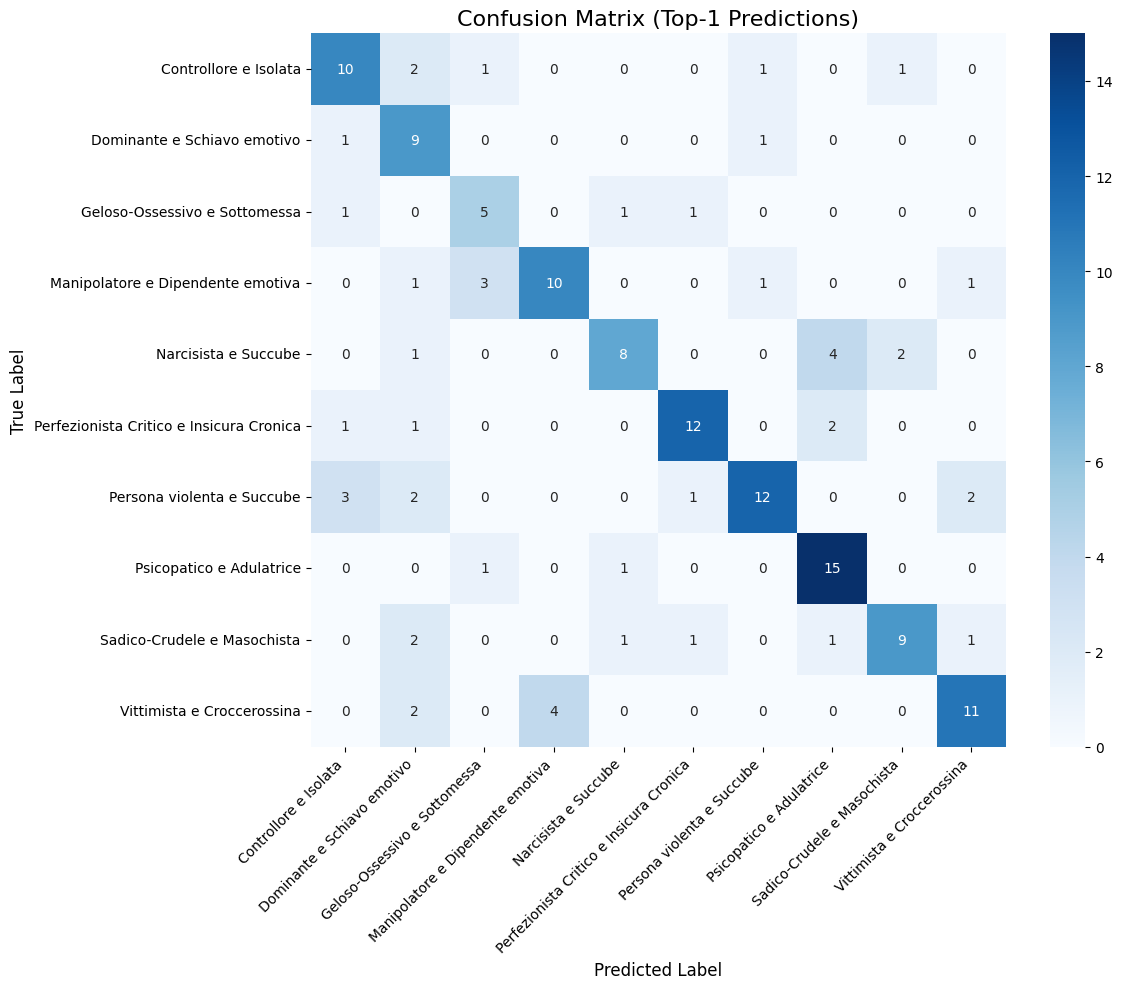

2025-08-14 11:44:53,508 [INFO] - Creating training progress plots...


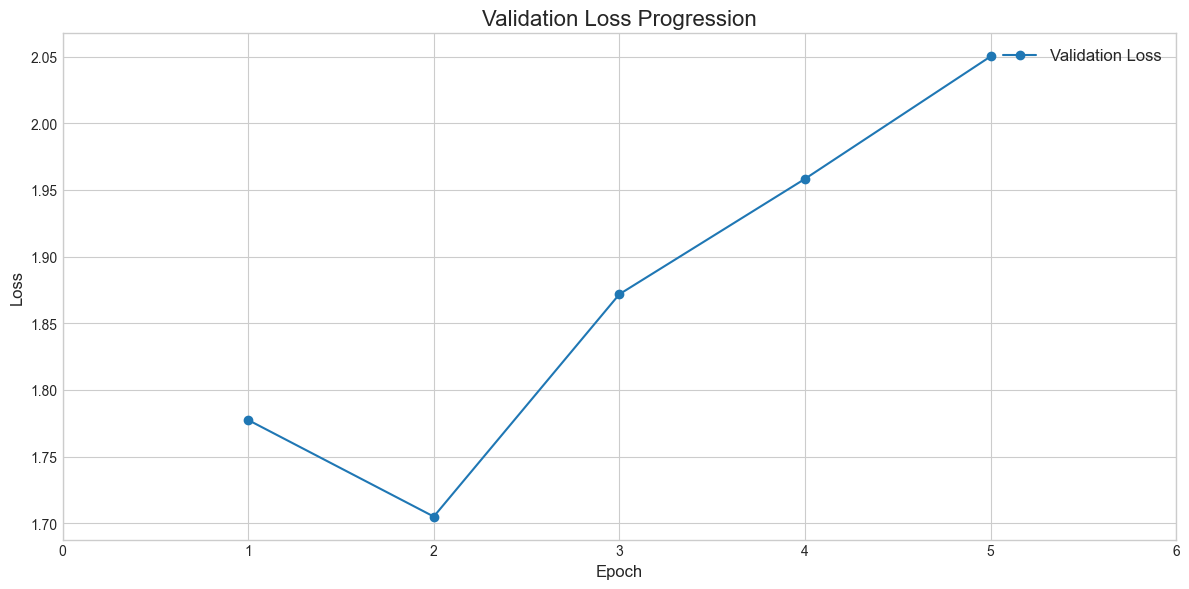

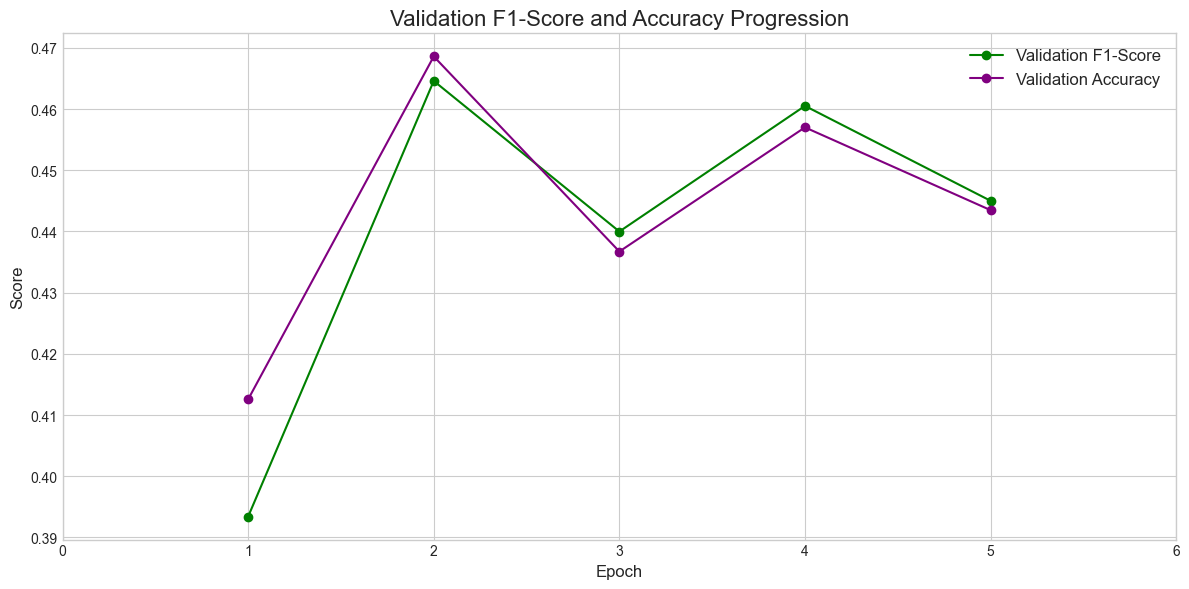

2025-08-14 11:44:55,332 [INFO] - Final model and tokenizer saved to './LLM_model_turn_based_final'

Process completed successfully!


In [9]:
logging.info("Calculating class weights...")
class_weights = compute_class_weight('balanced', classes=np.unique(final_train_df['label']), y=final_train_df['label'])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

logging.info(f"Loading pre-trained model: {MODEL_NAME}")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(unique_labels), id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True
)
model.class_weights = class_weights_tensor
model.resize_token_embeddings(len(tokenizer))

training_args = TrainingArguments(
    output_dir="./results/turn_based_classifier",
    report_to="none",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2
)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_for_trainer,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

logging.info("Starting model training...")
trainer.train()
logging.info("Training complete.")


# --- 3. Evaluation and Saving ---

logging.info("Starting custom evaluation phase...")
evaluator = LLMEvaluator(
    trainer=trainer,
    tokenized_test_set=tokenized_datasets["test"],
    test_turns_df=test_turns_df,
    raw_test_conversations=raw_test_conversations,
    id2label=id2label
)
evaluation_results = evaluator.evaluate_and_report()
evaluator.plot_confusion_matrix(y_true=evaluation_results['y_true'], y_pred=evaluation_results['y_pred_top1'])
evaluator.plot_training_history()

final_model_path = "./LLM_model_turn_based_final" # Saving to a local folder
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)
logging.info(f"Final model and tokenizer saved to '{final_model_path}'")

print("\nProcess completed successfully!")